## Multi-Armed Bandits Problem 

For this multi-armed bandit example, the action values, $q_*(a), a = 1, . . . , 10$ were selected according to a normal (Gaussian) distribution with mean 0 and variance 1. Then, when a learning method applied to that problem selected action $A_t$ at time $t$, the actual reward $R_t$ was selected from a normal distribution with mean $q_* (A_t)$ and variance 1.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random 

class Bandit(object):
    """10 armed bandit"""
    
    def __init__(self):
        self.action_vals = np.random.normal(0, 1, 10)
    
    """Bandit[A] returns the actual reward for action A"""
    def __getitem__(self, action):
        action_val = self.action_vals[action]
        return action_val + np.random.normal(action_val, 1)

### Action-value method using sample averages

Given $Q_n$ and the $n$th reward, $R_n$ , the new average of all $n$ rewards can be computed by: $$Q_{n+1}= Q_n + \frac{1}{n}[R_n - Q_n]$$

In [2]:
class EpsilonGreedyAgent(object):
    """An epsilon greedy action value method that uses sample averages"""
    
    def __init__(self, Bandit, epsilon):
        self.epsilon = epsilon
        self.bandit = Bandit()
        self.estimated_vals = np.zeros(10)
        self.num_a = np.zeros(10)  # num of times that each action has been selected
        
    def get_action(self):
        if(np.random.random() > self.epsilon):  
            return np.argmax(self.estimated_vals)
        else: 
            return np.random.randint(0, 10)
        
    def take_step(self):
        action = self.get_action()
        reward = self.bandit[action]
        self.num_a[action] += 1
        error = reward - self.estimated_vals[action]
        self.estimated_vals[action] += (1.0 / self.num_a[action]) * error
        return reward

For any learning method, we can
measure its performance and behavior as it improves with experience over 1000 steps
interacting with one of the bandit problem. This makes up one run. Repeating this
for 2000 independent runs with a different bandit problem, we obtain measures of
the learning algorithm’s average behavior.

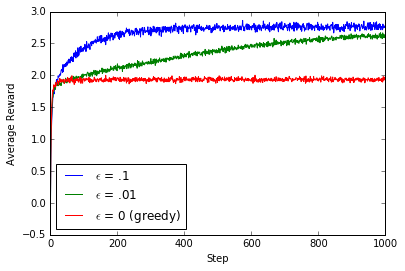

In [3]:
"""Returns reward history of a 1000 step run for a given agent"""   
def thousand_step_run(agent):
    reward_history = np.zeros(1000)
    for i in xrange(1000):
        reward_history[i] = agent.take_step()
    return reward_history

"""Average reward of 2000 agents each of which made a 1000 step run"""
def avg_reward(AgentClass, *args):
    reward_history = np.zeros(1000)
    for _ in xrange(2000):
        agent = AgentClass(*args)
        reward_history = np.add(reward_history, thousand_step_run(agent))
    return reward_history / 2000

x_axis = [x for x in xrange(1000)]
plt.plot(x_axis, avg_reward(EpsilonGreedyAgent, Bandit, .1), label="$\epsilon$ = .1")
plt.plot(x_axis, avg_reward(EpsilonGreedyAgent, Bandit, .01), label="$\epsilon$ = .01")
plt.plot(x_axis, avg_reward(EpsilonGreedyAgent, Bandit, 0), label="$\epsilon$ = 0 (greedy)")
plt.xlabel("Step")
plt.ylabel("Average Reward")
plt.legend(loc='best')
plt.show()

### Action-value method using a constant step-size parameter

The incremental update rule for updating an average $Q_n$ of the $n-1$ past rewards is modified to be: 

$$Q_{n+1} = Q_n + \alpha[R_n - Q_n]$$

where the step-size parameter α ∈ (0, 1] is constant. This results in $Q_{n+1}$ being a
weighted average of past rewards and the initial estimate $Q_1$:

$$Q_{n+1} = (1-\alpha)^nQ_1+\sum_{i=1}^{n}\alpha(1-\alpha)^{n-i}R_i  $$

**Exercise 2.3**:
Design and conduct an experiment to demonstrate
the difficulties that sample-average methods have for nonstationary problems. Use a
modified version of the 10-armed testbed in which all the $q_*(a)$ start out equal and
then take independent random walks. Prepare plots like Figure 2.2 for an action-
value method using sample averages, incrementally computed by α = $\frac{1}{n}$ , and another
action-value method using a constant step-size parameter, α = 0.1. Use ε = 0.1 and,
if necessary, runs longer than 1000 steps.

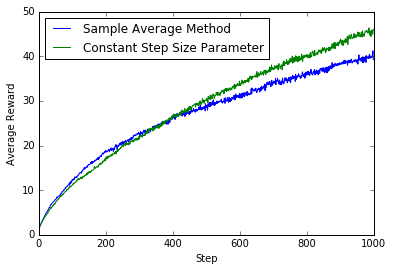

In [4]:
class NonStationaryBandit(object):
    """A bandit whos action values for each arm are non-stationary(take independent random walks)"""
    
    def __init__(self):
        self.action_values = np.ones(10)
        
    def __getitem__(self, action):
        random_steps = [random.uniform(-2, 2) for _ in xrange(10)]
        self.action_values = np.add(self.action_values, random_steps)
        return self.action_values[action]
    
    
class EpsilonGreedyConstStepSize(EpsilonGreedyAgent):
    """An epsilon greedy action value method that uses a constant step-size parameter"""
    
    def __init__(self, Bandit, epsilon, alpha):
        super(EpsilonGreedyConstStepSize, self).__init__(Bandit, epsilon)
        self.alpha = alpha
        
    def take_step(self):
        action = self.get_action()
        reward = self.bandit[action]
        self.num_a[action] += 1
        self.estimated_vals[action] += self.alpha * (reward - self.estimated_vals[action]) 
        return reward
    
sample_avg_method_reward = avg_reward(EpsilonGreedyAgent, NonStationaryBandit, .1)
const_step_size_reward = avg_reward(EpsilonGreedyConstStepSize, NonStationaryBandit, .1, .1)
plt.plot(x_axis, sample_avg_method_reward, label="Sample Average Method")
plt.plot(x_axis, const_step_size_reward, label="Constant Step Size Parameter")
plt.xlabel("Step")
plt.ylabel("Average Reward")
plt.legend(loc='best')
plt.show()